# Ames housing: LASSO regression with sklearn

Contents
 - load data
 - data manipulation
 - LASSO on housing data
   - fit model
   - coefficients
   - predictions
   - performance

Sources:
http://ww2.amstat.org/publications/jse/v19n3/decock.pdf

Copyright (C) 2018 Alan Chalk  
Please do not distribute or publish without permission.

## Start_.

**Import packages**

In [1]:
import os
import numpy as np
import pandas as pd
import pickle

from sklearn.linear_model import LassoCV, Lasso

import matplotlib.pyplot as plt
%matplotlib inline

**directories and paths**

In [2]:
# Set directories
print(os.getcwd())
dirRawData = "../input/"
dirPData   = "../PData/"

/home/jovyan/Projects/AmesHousing/PCode


**functions**

In [3]:
def fn_MAE(actuals, predictions):
    return np.round(np.mean(np.abs(predictions - actuals)))

def fn_RMSE(actuals, predictions):
    return np.round(np.sqrt(np.mean((predictions - actuals)**2)))

**Load data**

In [4]:
# load df_all
#df_all = pd.read_hdf(dirPData + '02_df_all.h5', 'df_all_onehot')

# load the dict_ that was saved to pickle
f_name = dirPData + '02_df.pickle'
with open(f_name, "rb") as f:
    dict_ = pickle.load(f)
    
df_all_onehot = dict_['df_all_onehot']

del f_name, dict_

df_all = df_all_onehot
del df_all_onehot

In [5]:
# load definitions of variables
#dict_ = {'vars_ind': vars_ind, 'idx_design': idx_design, 'idx_test': idx_test}
f_name = dirPData + '02_vars.pickle'
with open(f_name, "rb") as f:
    dict_ = pickle.load(f)
    
var_dep              = dict_['var_dep']
vars_ind_numeric     = dict_['vars_ind_numeric']
vars_ind_categorical = dict_['vars_ind_categorical']
vars_ind_onehot      = dict_['vars_ind_onehot']

del f_name, dict_

In [6]:
idx_train  = np.where(df_all['fold'].isin(np.arange(0,6)))[0]
idx_val    = np.where(df_all['fold'].isin([6,7]))[0]
idx_design = np.where(df_all['fold'].isin(np.arange(0,8)))[0]
idx_test   = np.where(df_all['fold'].isin([8,9]))[0]

In [7]:
vars_ind = vars_ind_numeric + vars_ind_onehot
len(vars_ind)

216

In [8]:
X = df_all[vars_ind].values

# Note "incorrect" use of standardisation - should fit it over train data only
# standardise each feature
X -= np.mean(X, axis=0)
X /= np.sqrt(np.mean(X ** 2, axis=0))

In [9]:
X_design = X[idx_design, :]
X_test   = X[idx_test, :]
y_design = df_all[var_dep].iloc[idx_design].copy().values.ravel()
y_test   = df_all[var_dep].iloc[idx_test].copy().values.ravel()

### Lasso with k-fold CV

TODO
 - What is k-fold cross validation?
 - When is better than the simple train-val split we used previously?
 - What is the optimal value for k?

**Instantiate and fit the model**

In [10]:
%%time
# note impact of selection='random' vs cyclical on time taken
lassoCV_ = LassoCV(fit_intercept=True
                   ,normalize=False
                   ,cv=10
                   ,random_state=2018
                   ,selection='random'
                  )

lassoCV_.fit(X=X_design, y=y_design)

CPU times: user 704 ms, sys: 2.96 ms, total: 707 ms
Wall time: 822 ms


Inspect the coefficients

**TODO**  
 - Is the intercept penalised?
 - How many non-zero coefficients are there?
 - Inspect the coefficients. 
   - Does the sign of the coefficients make sense
   - Can you interpret the magnitude of the coefficients?
   - Do the magnitude of any coefficients for (exterior quality) exter_qual makes sense?

In [11]:
lassoCV_.intercept_

180729.6617411338

In [12]:
df_coef = pd.DataFrame({'variable': vars_ind, 'coefficient': np.round(lassoCV_.coef_, 0)})
df_coef = df_coef[df_coef['coefficient'] != 0]
df_coef['sign'] = np.where(df_coef['coefficient'].values < 0, 'NEG', 'POS')
df_coef['coefficient_abs'] = np.abs(df_coef['coefficient'])
print(df_coef.shape) # 154/5 non zero 

(114, 4)


In [13]:
df_coef.sort_values('coefficient_abs', ascending=False, inplace=True)
df_coef.head()

,variable,coefficient,sign,coefficient_abs
12,gr_liv_area,28274.0,POS,28274.0
1,overall_qual,11856.0,POS,11856.0
3,year_built,9840.0,POS,9840.0
8,total_bsmt_sf,8803.0,POS,8803.0
5,bsmtfin_sf_1,8044.0,POS,8044.0


**Regularisation strength chosen**

In [14]:
np.log10(lassoCV_.alpha_)

2.5698648655570473

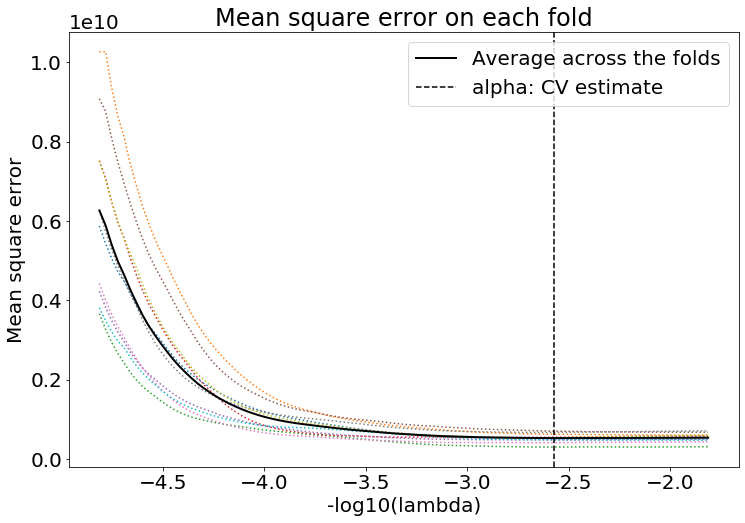

In [15]:
m_log_lambdas = -np.log10(lassoCV_.alphas_)

font = {'size': 20}
plt.rc('font', **font)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(m_log_lambdas, lassoCV_.mse_path_, ':')
ax1.plot(m_log_lambdas, lassoCV_.mse_path_.mean(axis=-1),
         'k',
         label='Average across the folds',
         linewidth=2)

ax1.axvline(-np.log10(lassoCV_.alpha_),
            linestyle='--', 
            color='k',
            label='alpha: CV estimate')

ax1.legend()

ax1.set_xlabel('-log10(lambda)')
ax1.set_ylabel('Mean square error')
ax1.set_title('Mean square error on each fold')
_ = ax1.axis('tight')

TODO

 - Does it "make sense" to choose the above regularisation strength for the final model?

**Predictions**

In [16]:
lassoCV_pred_design = lassoCV_.predict(X_design)
lassoCV_pred_test = lassoCV_.predict(X_test)

**TODO** 
 - Calculate the mean absolute error (MAE) of your predictions on design and test data (they will be based on lassoCV_.alpha_)

In [17]:
MAE_design = fn_MAE(y_design, lassoCV_pred_design)
MAE_test = fn_MAE(y_test, lassoCV_pred_test)
print("MAE: design:", MAE_design)
print("MAE: test:", MAE_test)

MAE: design: 13820.0
MAE: test: 14780.0


**TODO** 
 - Fit another model with higher penalisation but which does not loose much prediction power.
 - How many active predictors does it have?
 - What is the MAE?
 - Is the model simpler? Is it better?

In [18]:
np.log10(410)

2.6127838567197355

In [19]:
lasso_ = Lasso(alpha=410, # looking at above graph
               fit_intercept=True, 
               normalize=False, 
               random_state=2018)
lasso_.fit(X=X_design, y=y_design)
lasso_pred_test = lasso_.predict(X_test)
fn_MAE(y_test, lasso_pred_test)

14792.0

In [20]:
df_coef = pd.DataFrame({'variable': vars_ind, 'coefficient': np.round(lasso_.coef_)})
df_coef = df_coef[df_coef['coefficient'] != 0]
df_coef['sign'] = np.where(df_coef['coefficient'].values < 0, 'NEG', 'POS')
df_coef['coefficient_abs'] = np.abs(df_coef['coefficient'])
print(df_coef.shape) # 122/5 - much simpler model - and better 

(111, 4)


In [21]:
df_coef.sort_values('coefficient_abs', ascending=False, inplace=True)
df_coef.head()

,variable,coefficient,sign,coefficient_abs
12,gr_liv_area,28266.0,POS,28266.0
1,overall_qual,11977.0,POS,11977.0
3,year_built,9790.0,POS,9790.0
8,total_bsmt_sf,8757.0,POS,8757.0
5,bsmtfin_sf_1,8008.0,POS,8008.0


In [22]:
df_coef[df_coef['sign'] == 'NEG'].head()

,variable,coefficient,sign,coefficient_abs
17,bedroom_abvgr,-3299.0,NEG,3299.0
211,sale_condition_Abnorml,-2522.0,NEG,2522.0
97,bldg_type_TwnhsE,-2368.0,NEG,2368.0
18,kitchen_abvgr,-2327.0,NEG,2327.0
96,bldg_type_Twnhs,-2244.0,NEG,2244.0


In [23]:
df_coef.tail()

,variable,coefficient,sign,coefficient_abs
208,sale_type_CWD,18.0,POS,18.0
68,neighborhood_CollgCr,9.0,POS,9.0
54,lot_shape_IR3,-8.0,NEG,8.0
161,bsmtfin_type_2_DoesNotHaveOne,2.0,POS,2.0
196,garage_cond_DoesNotHaveOne,1.0,POS,1.0
